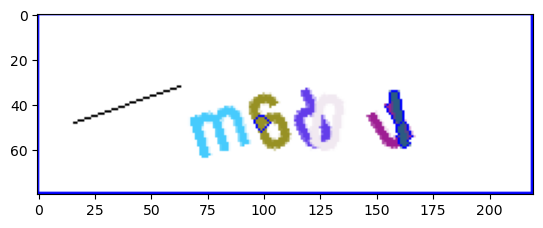

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load image and convert to grayscale
image = cv2.imread('train/m6d0ul-0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal with morphological operations
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region (overlapping area)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so background is not 0, but 1
markers = markers + 1

# Mark the unknown region with 0
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0] 

# display using plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()




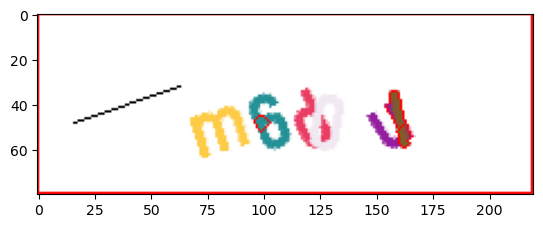

In [14]:
image = cv2.imread('train/m6d0ul-0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
plt.imshow(thresh, cmap='gray')

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.imshow(sure_fg)
plt.imshow(sure_bg)
plt.imshow(unknown)

# Marker labelling
# Connected Components determines the connectivity of blob-like regions in a binary image.
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]

plt.imshow(image)

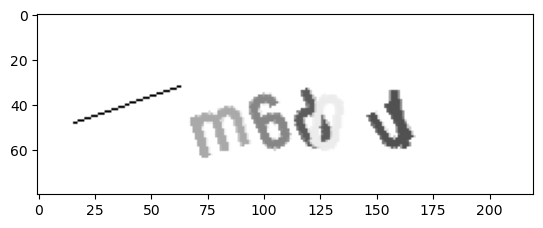

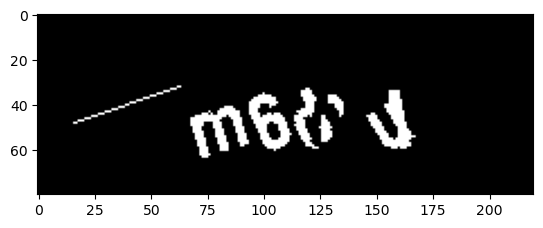

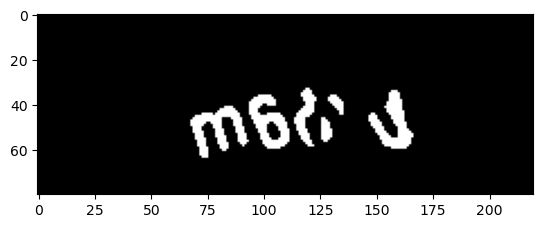

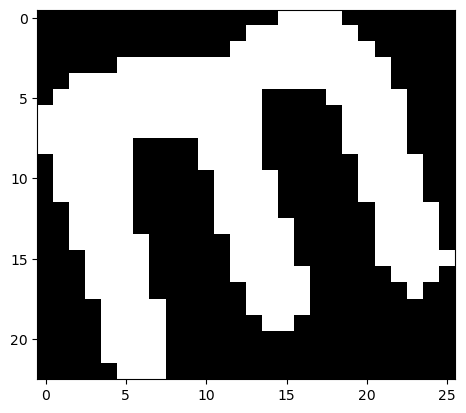

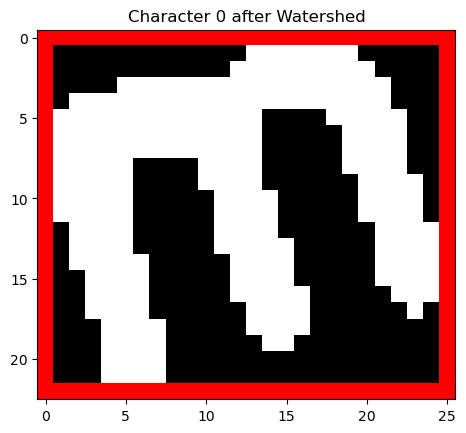

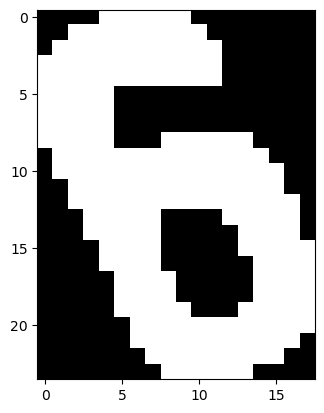

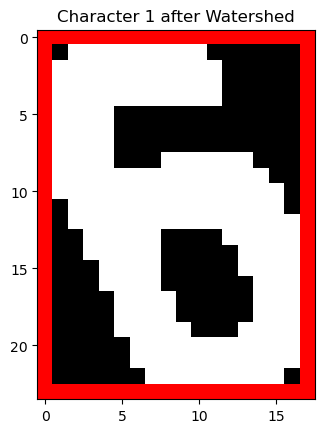

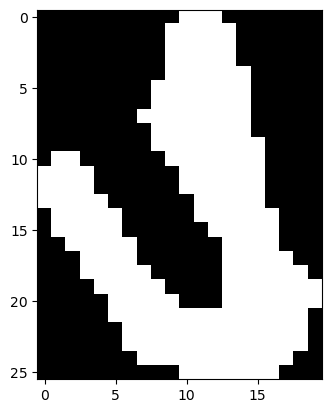

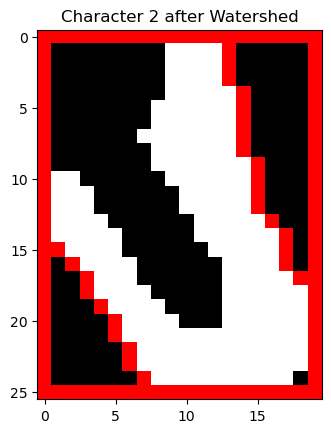

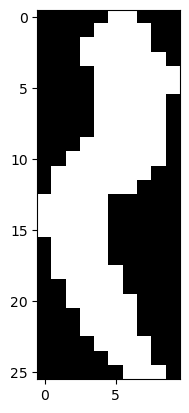

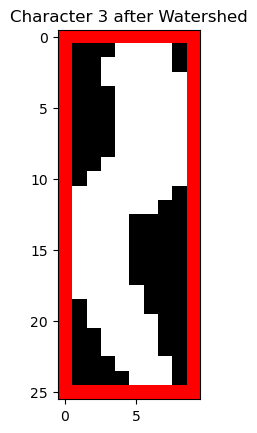

Segmentation completed!


In [13]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
    

# Create output folder for segmented characters
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the CAPTCHA image
image_path = "train/m6d0ul-0.png"  
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

im_bw_inverted = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 2)

plt.imshow(im_bw_inverted, cmap='gray')
plt.show()


im_bw_inverted = cv2.medianBlur(im_bw_inverted, 3)
plt.imshow(im_bw_inverted, cmap='gray')
plt.show()

# Adjust kernel size for closing operation
kernel = np.ones((3, 3), np.uint8)  # Larger kernel for closing
closed = cv2.morphologyEx(im_bw_inverted, cv2.MORPH_CLOSE, kernel)

# Find contours again after applying closing operation
cnts = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

min_area = 50  # Lowered min area to capture smaller parts like dots
image_number = 0

for c in cnts:
    area = cv2.contourArea(c)
    if area > min_area:
        x, y, w, h = cv2.boundingRect(c)
        # Draw a rectangle around each detected character
        cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 2)
        # Extract each character as a Region of Interest (ROI)
        ROI = closed[y:y+h, x:x+w]
        plt.imshow(ROI, cmap='gray')
        plt.show()
        
        # Further process the ROI with watershed to separate overlapping characters
        # Apply adaptive thresholding and distance transform on ROI
        roi_thresh = cv2.adaptiveThreshold(ROI, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
        dist_transform = cv2.distanceTransform(roi_thresh, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

        # Find background and unknown regions within ROI
        sure_fg = np.uint8(sure_fg)
        sure_bg = cv2.dilate(roi_thresh, kernel, iterations=3)
        unknown = cv2.subtract(sure_bg, sure_fg)

        # Marker labelling for watershed within the ROI
        ret, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0

        # Apply watershed on ROI
        color_roi = cv2.cvtColor(ROI, cv2.COLOR_GRAY2BGR)
        markers = cv2.watershed(color_roi, markers)
        color_roi[markers == -1] = [255, 0, 0]  # Optional: mark boundaries in red

        # Display each processed ROI
        plt.imshow(color_roi)
        plt.title(f"Character {image_number} after Watershed")
        plt.show()

        
        # Save the character as an individual image
        cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
        image_number += 1

print("Segmentation completed!")
